In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [13]:
data = pd.read_csv('EV_data.csv')
ID_26 = data['ID:26']     #Car_ID:26
ID_370 = data['ID:370']   #Car_ID:370
ID_545 = data['ID:545']   #Car_ID:545
ID_661 = data['ID:661']   #Car_ID:661
ID_4767 = data['ID:4767'] #Car_ID:4767

In [14]:
#Creating and resizing EV_array into (ID , Week, DOW, HOD)
ev_array = np.array([ID_26, ID_370, ID_545, ID_661, ID_4767])
ev_array.resize(5,47,7,24)

/Users/mathildebadoual/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


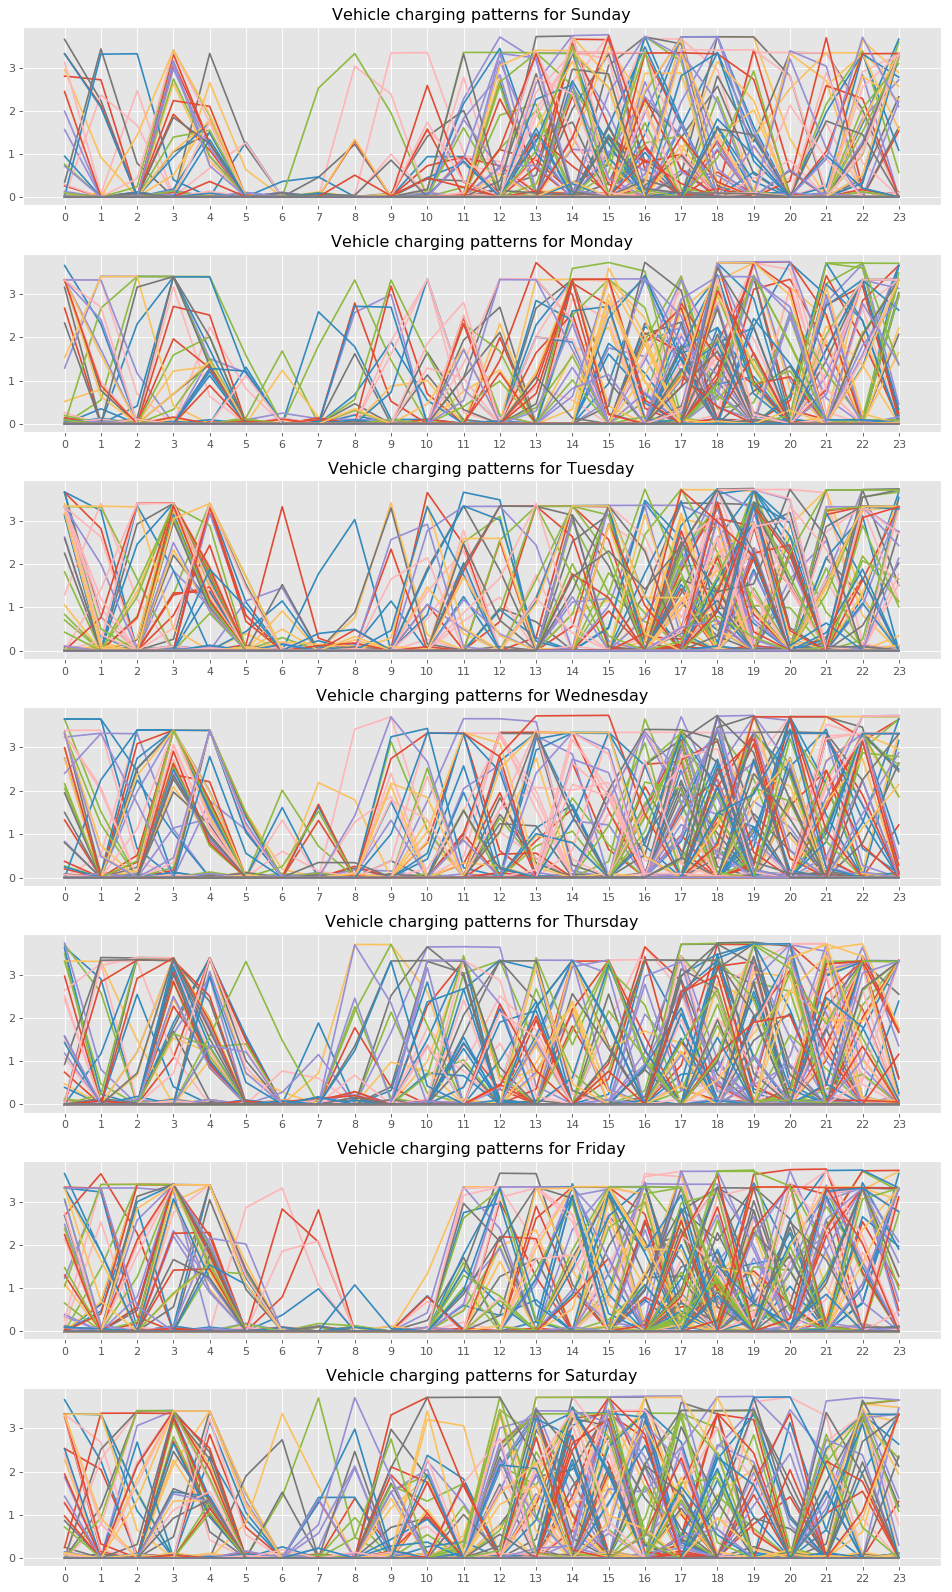

In [15]:
#Plotting charging patterns for each day of the week
day_list = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plt.figure(dpi = 80, figsize = (12,20), tight_layout = True)
for i in range(7):
    plt.subplot(7,1,i + 1)
    for j in range(47):
        for k in range(5):
            plt.plot(np.linspace(0,23,24), ev_array[k,j,i,:])
            plt.title('Vehicle charging patterns for %s' %day_list[i])
            plt.xticks(np.linspace(0,23,24))

In [16]:
##Creating mean plots for each day of the week
# plt.figure(dpi = 80, figsize = (10,12))
# for i in range(7):
#     plt.subplot(7, 1, i+1)
#     mean = []
#     for j in range(24):
#         mean.append(np.mean(ev_array[:,:,i,j]))
#     plt.plot(np.linspace(0,23,24), mean)

In [17]:
##Creating plots of the Standard deviation for each day
# plt.figure(dpi = 80, figsize = (10,12))
# for i in range(7):
#     plt.subplot(7, 1, i+1)
#     std = []
#     for j in range(24):
#         std.append(np.std(ev_array[:,:,i,j]))
#     plt.plot(np.linspace(0,23,24), std)

# MARKOV CHAIN 1:
For this, we are generating the matrices p_ij(k) which gives the probability of a car transitioning state from charging(i) to not charging(j)

In [23]:
#Creating Markov chain!
#Considering (5 x 47 x 7 ) different data arrays, we find the probablility
#matrix pij(k), i for charging, j for not charging.
#At each time step we count the 
p_list =[ ]  #initializing list containing the probability matrices
for k in range(23):  # 23 cuz probability doesn't count for last timestep
    Num_charging = [0, 0, 0]     #[num_charging now, num_STILL charging at k+1, num_n0t charging at k+1]
    Num_not_charging = [0, 0, 0] #[num_not charging now, num_charging next k, num STILL not charging next k]
    for i in range(5):
        for j in range(47):
            for v in range(7):
                if ev_array[i,j,v,k] >= 0.3:   #This can be adjusted (the normal full charging power is roughly 3.2kW)
                    Num_charging[0] += 1
                    if ev_array[i,j,v,k+1] >= 0.3:
                        Num_charging[1] += 1
                    else:
                        Num_charging[2] += 1
                else:
                    Num_not_charging[0] += 1
                    if ev_array[i,j,v,k+1] >= 0.3:
                        Num_not_charging[1] += 1
                    else:
                        Num_not_charging[2] += 1
    p_ij = np.zeros((2,2))
    p_ij[0,0] = Num_charging[1]/Num_charging[0]  #probability of moving from i to i
    p_ij[0,1] = Num_charging[2]/Num_charging[0]  #probability of moving from i to j
    p_ij[1,0] = Num_not_charging[1]/Num_not_charging[0] 
    p_ij[1,1] = Num_not_charging[2]/Num_not_charging[0]
    p_list.append(p_ij)

(23, 2, 2)


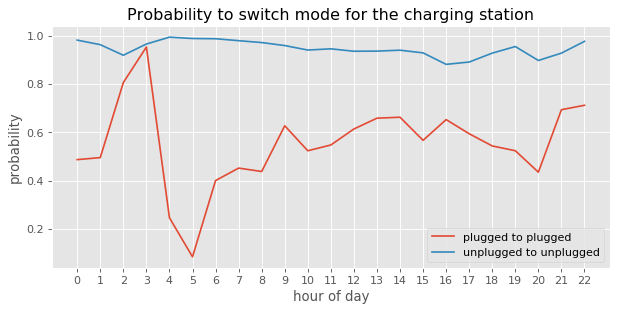

In [27]:
p_array = np.array(p_list)
print(p_array.shape)
fs =14

plt.figure(dpi = 80, figsize = (9,4), tight_layout = False)
plt.plot(np.linspace(0,22,23), p_array[:,0,0], label = 'plugged to plugged')
plt.plot(np.linspace(0,22,23), p_array[:,1,1], label = 'unplugged to unplugged')
#plt.plot(np.linspace(0,22,23), p_array[:,0,1], label = 'unplugged to plugged')
#plt.plot(np.linspace(0,22,23), p_array[:,1,0], label = 'plugged to unplugged')
plt.xticks(np.linspace(0,22,23))
plt.ylabel('probability', fontsize = fs-2)
plt.xlabel('hour of day', fontsize = fs-2)
plt.title('Probability to switch mode for the charging station')
plt.legend()
plt.show()

#p_array.shape

# MARKOV CHAIN 2:
For this one, we assume that all 5 car types visit the charging station and we compute the probabilities(p_ij) using the aggregate data: Thus, p_ii(k) is probabilty that if any car is charging now, the any car will be charging at k+1. p_jj(k) is the probability that if no car is charging now, then no car will be charging at k+1

I think this one is more like a station

In [28]:
#Creating Markov chain!
#Considering (5 x 47 x 7 ) different data arrays, we find the probablility
#matrix pij(k), i for charging, j for not charging.
#At each time step we count the 
p_list =[ ]  #initializing list containing the probability matrices
for k in range(23):  # 23 cuz probability doesn't count for last timestep
    Num_charging = [0, 0, 0]     #[num_charging now, num_STILL charging at k+1, num_n0t charging at k+1]
    Num_not_charging = [0, 0, 0] #[num_not charging now, num_charging next k, num STILL not charging next k]
    for j in range(47):
        for v in range(7):
            if any(i >= 0.3 for i in ev_array[:,j,v,k]): #I use 0.3 as charging benchmark
                Num_charging[0] += 1
                if any(i >= 0.3 for i in ev_array[:,j,v,k+1]):
                    Num_charging[1] += 1
                else:
                    Num_charging[2] += 1
            else:
                Num_not_charging[0] += 1
                if any(i >= 0.3 for i in ev_array[:,j,v,k+1]):
                    Num_not_charging[1] += 1
                else:
                    Num_not_charging[2] += 1
    p_ij = np.zeros((2,2))
    p_ij[0,0] = Num_charging[1]/Num_charging[0]  #probability of moving from i to i
    p_ij[0,1] = Num_charging[2]/Num_charging[0]  #probability of moving from i to j
    p_ij[1,0] = Num_not_charging[1]/Num_not_charging[0] 
    p_ij[1,1] = Num_not_charging[2]/Num_not_charging[0]
    p_list.append(p_ij)
    

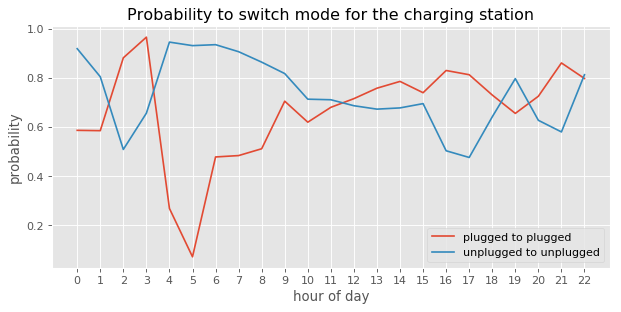

In [31]:
P = np.array(p_list)
fs = 14

plt.figure(dpi = 80, figsize = (9,4), tight_layout = False)
plt.plot(np.linspace(0,22,23), p_array[:,0,0], label = 'plugged to plugged')
plt.plot(np.linspace(0,22,23), p_array[:,1,1], label = 'unplugged to unplugged')
plt.xticks(np.linspace(0,22,23))
plt.ylabel('probability', fontsize = fs-2)
plt.xlabel('hour of day', fontsize = fs-2)
plt.title('Probability to switch mode for the charging station')
plt.legend()
plt.show()

#p_array.shape